In [1]:
%matplotlib inline
import holidays

import pandas as pd
import numpy as np
from fbprophet import Prophet

In [2]:
def get_data():
    data = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/flights.csv')
    data['ds'] = pd.to_datetime(
        data.apply(lambda x: "{}/{}/01".format(x['year'], x['month']), axis=1), 
        format="%Y/%B/%d")

    return (
        data
        .set_index('ds')
        .drop(['year', 'month'], axis=1)
        .resample('1D')
        .interpolate('linear')
        .rename(columns={"passengers": "y"})
        .reset_index()
    )
    

In [3]:
df = get_data()
df.head()

,ds,y
0,1949-01-01,112.000000
1,1949-01-02,112.193548
2,1949-01-03,112.387097
3,1949-01-04,112.580645
4,1949-01-05,112.774194


In [4]:
df['ds'][0]

Timestamp('1949-01-01 00:00:00')

In [5]:
cal = holidays.France(years=np.unique(pd.DatetimeIndex(df['ds']).year))

holidays_df = pd.DataFrame({
    "ds": list(cal.keys()), 
    "holiday": list(cal.values()), 
    "lower_window": 0,
    "upper_window": 0
})

holidays_df.head()

,ds,holiday,lower_window,upper_window
0,1956-05-08,Victoire 1945,0,0
1,1949-06-06,Lundi de Pentecôte,0,0
2,1959-03-30,Lundi de Pâques,0,0
3,1956-01-01,Nouvel an,0,0
4,1954-07-14,Fete Nationale,0,0


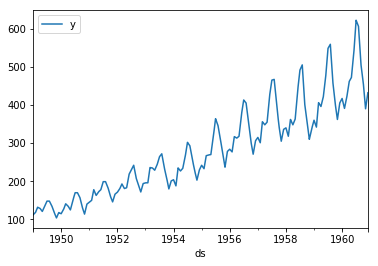

In [6]:
df.set_index('ds').plot()

In [7]:
m = Prophet(growth='linear', 
            changepoints=None, 
            n_changepoints=25, 
            yearly_seasonality=True, 
            weekly_seasonality=True, 
            holidays=holidays_df,  # to add holidays effect
            seasonality_prior_scale=10.0,
            holidays_prior_scale=10.0, 
            changepoint_prior_scale=0.05,
            mcmc_samples=500,  # to add intervals in season and week
            interval_width=0.8, 
            uncertainty_samples=1000)
m.fit(df);

In [8]:
future = m.make_future_dataframe(freq='1D', periods=365)
future.tail()

,ds
4713,1961-11-27
4714,1961-11-28
4715,1961-11-29
4716,1961-11-30
4717,1961-12-01


In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4713,1961-11-27,508.707617,425.266377,598.336879
4714,1961-11-28,509.677499,426.387102,596.977877
4715,1961-11-29,510.466924,426.131789,601.007995
4716,1961-11-30,511.261366,426.278462,602.243406
4717,1961-12-01,511.993688,425.027619,602.358725


<IPython.core.display.Javascript object>


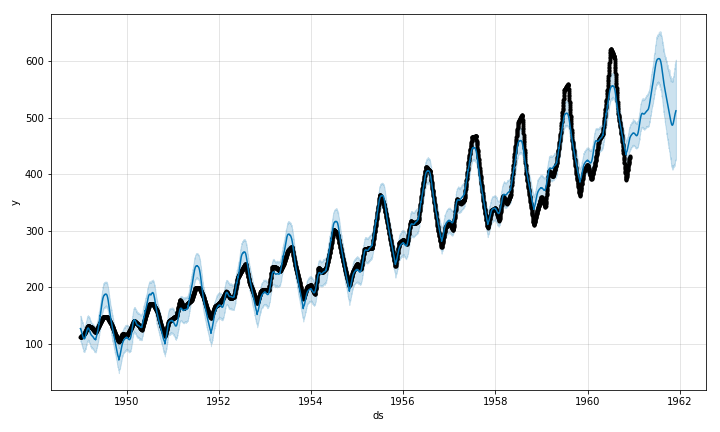

In [15]:
%matplotlib notebook
#%matplotlib inline
m.plot(forecast);

<IPython.core.display.Javascript object>


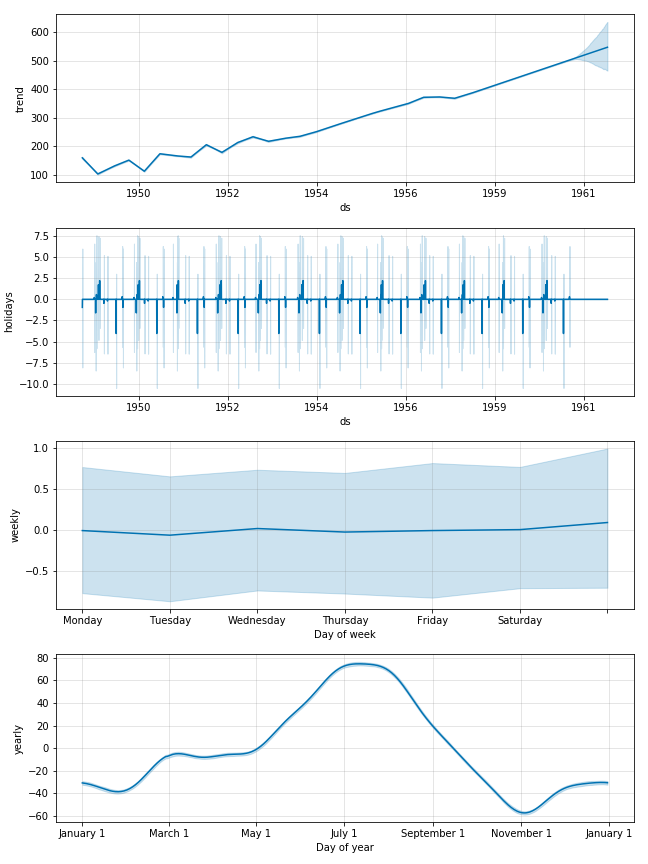

<IPython.core.display.Javascript object>


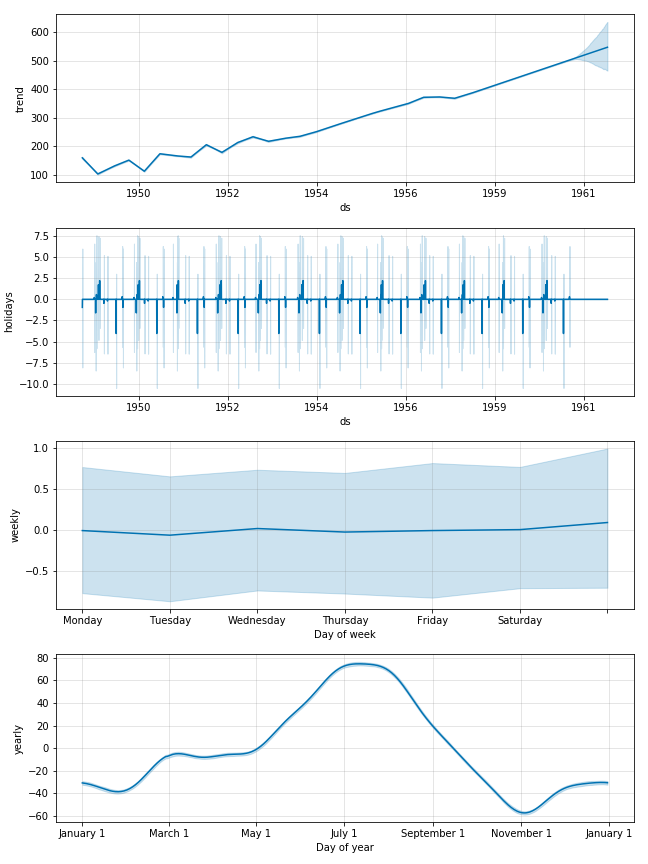

In [16]:
m.plot_components(forecast)

In [12]:
test = pd.concat([df.set_index('ds'), forecast.set_index('ds')], axis=1)
#test = test[~test['y'].isnull()]
print('RMSE', np.sqrt(((test['y'] - test['yhat'])**2).mean()))
print('MeanAE', ((test['y'] - test['yhat']).abs()).mean())
print('MedianAE', ((test['y'] - test['yhat']).abs()).median())
print('MAPE', ((test['y'] - test['yhat']).abs()/ test['y']).mean() * 100)

RMSE 16.6850876508
MeanAE 12.2191727338
MedianAE 8.879121722746106
MAPE 4.93255591311


In [13]:
test = pd.concat([df.set_index('ds'), forecast.set_index('ds')], axis=1)
#test = test[~test['y'].isnull()]
print('RMSE', np.sqrt(((test['y'] - test['yhat'])**2).mean()))
print('MeanAE', ((test['y'] - test['yhat']).abs()).mean())
print('MedianAE', ((test['y'] - test['yhat']).abs()).median())
print('MAPE', ((test['y'] - test['yhat']).abs()/ test['y']).mean() * 100)
print('CVRMSE',  np.sqrt(((test['y'] - test['yhat'])**2).mean())/np.nanmean(test['y']) * 100)

RMSE 16.6850876508
MeanAE 12.2191727338
MedianAE 8.879121722746106
MAPE 4.93255591311
CVRMSE 5.94698140448


In [14]:
out = forecast.set_index('ds').drop('t', axis=1)

In [ ]:
out.to_csv('./data/prophet_forecast-tsdata.csv')